## Hypothesis Testing

## Import statements

In [228]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from statsmodels.stats.weightstats import ztest
import statsmodels.api as sm
import math as mt
import random as rd
import time as tm

## Data Preperation

In [229]:
# Data Loading
file_link = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/293/original/walmart_data.csv?1641285094"
raw_data = pd.read_csv(file_link)

# Data Cleaning
clean_data = raw_data.reset_index().copy()
clean_data['User_ID'] = clean_data['User_ID'].astype('str')
clean_data['Product_ID'] = clean_data['Product_ID'].astype('str')
clean_data.rename(columns={'index': 'Transaction_ID'}, inplace=True, errors='ignore')
clean_data['Transaction_ID'] = clean_data['Transaction_ID'].astype('str')
columns_to_convert = {
    'Gender', 'Age','Occupation',
    'Marital_Status', 'Product_Category',
    'City_Category', 'Stay_In_Current_City_Years'
}

for column in columns_to_convert:
    if column in {'Marital_Status'}:
        clean_data[column] = clean_data[column].apply(lambda x: 'Married' if x == 1 else 'Unmarried')
    elif column in {'Product_Category', 'Occupation'}:
        clean_data[column] = clean_data[column].apply(lambda x: f'{column}_{str(x)}')
    clean_data[column] = clean_data[column].astype('category')

# Data Preperation
iqr = clean_data['Purchase'].quantile(0.75) - clean_data['Purchase'].quantile(0.25)
lower_bound = clean_data['Purchase'].quantile(0.25) - 1.5 * iqr
upper_bound = clean_data['Purchase'].quantile(0.75) + 1.5 * iqr

analysis_data = (
    clean_data
    .drop(columns=['Occupation', 'Product_Category', 'Product_ID'])
    )

id_columns = ['User_ID', 'Transaction_ID']
categorical_columns = analysis_data.select_dtypes(include='category').columns.tolist()
numerical_columns = analysis_data.select_dtypes(include='number').columns.tolist()

bins = [0, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000]
labels = [f'{bins[i]} - {bins[i+1]}' for i in range(len(bins)-1)]

analysis_data['Purchase_Bucket'] = pd.cut(analysis_data['Purchase'], bins= bins, labels= labels, right= False)

numerical_bucketed_columns = ['Purchase_Bucket']

analysis_data.head()

,Transaction_ID,User_ID,Gender,Age,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase,Purchase_Bucket
0,0,1000001,F,0-17,A,2,Unmarried,8370,7500 - 10000
1,1,1000001,F,0-17,A,2,Unmarried,15200,15000 - 17500
2,2,1000001,F,0-17,A,2,Unmarried,1422,1000 - 2500
3,3,1000001,F,0-17,A,2,Unmarried,1057,1000 - 2500
4,4,1000002,M,55+,C,4+,Unmarried,7969,7500 - 10000


In [230]:
# Data Aggregation

def get_size(collection):
    if type(collection) in {str, int, float}:
        return 1
    elif type(collection) in {list, set, dict}:
        n = 0
        collections = collection.values() if type(collection) == dict else collection
        for sub_collection in collections:
            n += get_size(sub_collection)
        return n
    else:
        return 0

def remove_agg_prefixes(name, prefixes, trim= True):
    for prefix in prefixes:
        name = name.replace(prefix, '')
    
    name = name.strip()

    return name


def get_agg_data(data, groupby_coulmns, base_aggs, custom_aggs, include= 'custom', ret_agg_names= False):
    base_agg_data = data.groupby(groupby_coulmns, observed= True).agg(**base_aggs)
    base_agg_names = list(base_aggs.keys())
    if include == 'base':
        if ret_agg_names:
            return base_agg_data.reset_index(), base_agg_names
        return base_agg_data.reset_index()

    custom_agg_names = []
    agg_data = base_agg_data.copy()
    for agg_type, agg_columns in custom_aggs.items():
        if agg_type == '%':
            for column in agg_columns:
                new_column = remove_agg_prefixes(column, ['#', '$'])
                agg_data[f'% {new_column}'] = agg_data[column] * 100 / agg_data[column].sum()
                custom_agg_names.append(f'% {new_column}')
        elif agg_type == 'Avg.':
            for numerator, denominators in agg_columns.items():
                new_numerator = remove_agg_prefixes(numerator, ['#', '$'])
                for denominator in denominators:
                    new_denominator = remove_agg_prefixes(denominator, ['#', '$'])
                    agg_data[f'Avg. {new_numerator} per {new_denominator}'] = agg_data[numerator] / agg_data[denominator]
                    custom_agg_names.append(f'Avg. {new_numerator} per {new_denominator}')
    
    if include == 'both':
        if ret_agg_names:
            return agg_data.reset_index(), base_agg_names + custom_agg_names
        return agg_data.reset_index()

    if ret_agg_names:
        return agg_data.drop(columns= base_agg_data.columns.tolist()).reset_index(), custom_agg_names
    return agg_data.drop(columns= base_agg_data.columns.tolist()).reset_index()

user_base_aggs = {
    '# Transaction': ('Transaction_ID', 'count'),
    '$ Revenue': ('Purchase', 'sum')
}

user_custom_aggs = {
    'Avg.': {
        '$ Revenue': ['# Transaction']
    }
}

user_agg_data, user_agg_columns = get_agg_data(analysis_data, ['User_ID'] + categorical_columns, user_base_aggs, user_custom_aggs, include= 'both', ret_agg_names= True)

user_agg_data.head()

,User_ID,Gender,Age,City_Category,Stay_In_Current_City_Years,Marital_Status,# Transaction,$ Revenue,Avg. Revenue per Transaction
0,1000001,F,0-17,A,2,Unmarried,35,334093,9545.514286
1,1000002,M,55+,C,4+,Unmarried,77,810472,10525.610390
2,1000003,M,26-35,A,3,Unmarried,29,341635,11780.517241
3,1000004,M,46-50,B,2,Married,14,206468,14747.714286
4,1000005,M,26-35,A,1,Married,106,821001,7745.292453


**Test Hypothesis Framework**

*Metric: Avg purchase amount per transaction*

*Null Hypothesis: There is no significant difference between the variables*

| Variable          | Variable Type | Cardinality   | Alternate Hypothesis       |
| :---------------- | :------------ | :------------ | :------------------------- |
| Gender            | Categorical   | 2             | Greater for Male           |
| Marital_Status    | Categorical   | 2             | Greater for Unmarried      |
| Age               | Categorical   | 6             | Greater for (26-35 / 18-45)|
| City_Category     | Categorical   | 3             | Lesser for City C          |


**Choice of Test Framework**

```yaml
Variable Type
├── Numerical vs Categorical:
│   ├── Cardinality = 2:
│   |   ├── Normal: Yes → Two Sample T-Test Independent
│   |   └── Normal: No → Two Sample KS-Test
│   └── Cardinality > 2: No  → Outcome B
│       ├── Normal and Homoscedastic: Yes → Two Sample ANOVA
│       └── Normal and Homoscedastic: No → Kruskal-Wallis Test
├── Categorical vs Categorical:
└── Numerical vs Numerical:
```

## Gender

*Metric: Avg purchase amount per transaction*

*Null Hypothesis (H0): There is no significant difference between the male vs female customers*

*Alternate Hypothesis(Ha): Male avg purchase amount per transaction is greater than female*


In [231]:
# Checking for data types and cardinality and sample size

print(user_agg_data['Avg. Revenue per Transaction'].dtype, user_agg_data['Gender'].dtype)

print(user_agg_data['Avg. Revenue per Transaction'].shape, user_agg_data['Gender'].nunique())

user_agg_data['Gender'].value_counts()

float64 category
(5891,) 2


Gender
M    4225
F    1666
Name: count, dtype: int64

*Sample size: 5891 (no. of customers)*

*Data Types: Avg Revenue per Transaction is Numerical and Gender is categorical*

*Cardinality: Gender has 2 values M (male: 4225) and F (female: 1666)*

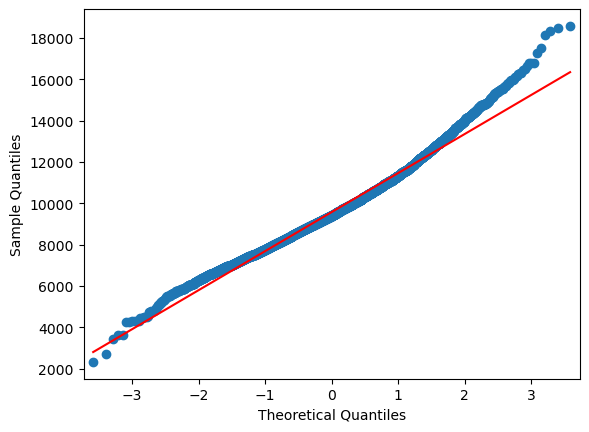

The sample data not follow a normal distribution at 95% confidence level with ks_stat: 1.0, p_val: 0.0


In [232]:
# Checking for Normality of the metric using QQ plot and KS Test (one sample - theoretical normal)

sm.qqplot(user_agg_data['Avg. Revenue per Transaction'], line= 's')
plt.show()

ks_stat, p_val = st.kstest(user_agg_data['Avg. Revenue per Transaction'], 'norm')

alpha = 0.05
if p_val > alpha:
    print(f"The sample data follows a normal distribution at {int((1 - alpha)*100)}% confidence level with ks_stat: {ks_stat}, p_val: {p_val}")
else:
    print(f"The sample data not follow a normal distribution at {int((1 - alpha)*100)}% confidence level with ks_stat: {ks_stat}, p_val: {p_val}")

### Observations:
- The qq plot looks mostly linear with outliers towards the right, 
- The ks test shows that the sample is not following a normal distribution

In [233]:
male_purchase_data = user_agg_data[user_agg_data['Gender'] == 'M']['Avg. Revenue per Transaction']
female_purchase_data = user_agg_data[user_agg_data['Gender'] == 'F']['Avg. Revenue per Transaction']

**Assumption: Average spending does not follow a normal distribution as per the ks test**

**Checking for the null hypothesis using Two Sample KS Test with two tailed alternative hypothesis**


In [234]:
ks_stat, p_val = st.kstest(male_purchase_data, female_purchase_data, alternative= 'two-sided')

print(f"ks_stat: {ks_stat:4f}, p_val: {p_val:4f}")


alpha = 0.05
if p_val > alpha:
    print(f"There is not significant difference between Male and Female purchase distributions at {int((1 - alpha)*100)}% confidence level")
else:
    print(f"There is a significant difference between Male and Female purchase distributions at {int((1 - alpha)*100)}% confidence level")

ks_stat: 0.219469, p_val: 0.000000
There is a significant difference between Male and Female purchase distributions at 95% confidence level


### Observations:
- The average spending amount **is significantly different** for male vs female customers

**Assumption: Average spending follows almost normal distribution as per the qq plot, despite the ks test not showing significance**

In [235]:
male_purchase_data.mean(), female_purchase_data.mean()

(9806.867524226629, 8965.19846393646)

**Checking for the null hypothesis using Two Sample T Test with left tailed alternative hypothesis (male spending is greater than female)**

*Left tailed test because mean of avg purchase amount for male is higher than female*

In [236]:
t_stat, p_val = st.ttest_ind(male_purchase_data, female_purchase_data, alternative= 'greater')

print(f"t_stat: {t_stat:4f}, p_val: {p_val:4f}")


alpha = 0.05
if p_val > alpha:
    print(f"There is no significant difference between avg spending for Male and Female users at {int((1 - alpha)*100)}% confidence level")
else:
    print(f"Male avg purchase amount is significantly greater than Female at {int((1 - alpha)*100)}% confidence level")

t_stat: 15.710671, p_val: 0.000000
Male avg purchase amount is significantly greater than Female at 95% confidence level


### Observations:
- Male avg purchase amount is significantly greater than Female as per the left tailed t-test at 95% confidence level

**Calculating the confidence intervals for male and female avg purchase amount**

In [237]:
male_purchase_size, male_purchase_mean, male_purchase_std = male_purchase_data.shape[0], male_purchase_data.mean(), male_purchase_data.std()
female_purchase_size, female_purchase_mean, female_purchase_std = female_purchase_data.shape[0], female_purchase_data.mean(), female_purchase_data.std()

male_purchase_se, female_purchase_se = male_purchase_std / mt.sqrt(male_purchase_size), female_purchase_std / mt.sqrt(female_purchase_size)

width = 0.95

lower_width, upper_width = (1 - width)/2, width - ((1-width)/2)
male_purchase_lower, male_purchase_upper = male_purchase_mean + (st.norm.ppf(lower_width) * male_purchase_se), male_purchase_mean + (st.norm.ppf(upper_width) * male_purchase_se)
female_purchase_lower, female_purchase_upper = female_purchase_mean + (st.norm.ppf(lower_width) * female_purchase_se), female_purchase_mean + (st.norm.ppf(upper_width) * female_purchase_se)

print(f"Male population avg purchase amount {int(width*100)}% confidence interval: {male_purchase_lower:2f} - {male_purchase_upper:2f}")
print(f"Female population avg purchase amount {int(width*100)}% confidence interval: {female_purchase_lower:2f} - {female_purchase_upper:2f}")

Male population avg purchase amount 95% confidence interval: 9749.383406 - 9849.087789
Female population avg purchase amount 95% confidence interval: 8883.296988 - 9025.352504


### Observations:

- There is no overlap between male (9749.4 - 9849.1) and female (8883.3 - 9025.3) avg purchase amount for the population at 95% confidence interval

**Validating the overlap of confidence intervals for male and female avg purchase amount at different widths and sample sizes**

In [238]:
def get_confidence_interval(data, sample_pct, width):
    if sample_pct < 1:
        sample_data = data.sample(frac= sample_pct)
    else:
        sample_data = data

    sample_size, sample_mean, sample_std = sample_data.shape[0], sample_data.mean(), sample_data.std()

    sample_se = sample_std / mt.sqrt(sample_size)

    lower_width, upper_width = (1 - width)/2, width - ((1-width)/2)
    sample_lower, sample_upper = (
        sample_mean + (st.norm.ppf(lower_width) * sample_se),
        sample_mean + (st.norm.ppf(upper_width) * sample_se)
        )

    return [sample_lower, sample_upper]

def check_overlap(left_interval, right_interval):
    if len(left_interval) != 2 or len(right_interval) != 2:
        return 'Invalid inteval size'
    
    if (left_interval[0] > left_interval[1]) or (right_interval[0] > right_interval[1]):
        return 'Invalid interval order'
    
    if left_interval[1] < right_interval[0] or right_interval[1] < left_interval[0]:
        return 'No Overlap'
    
    return 'Overlap'

In [239]:
params = {
    'width': [0.90, 0.95, 0.99],
    'sample_pct': [0.10, 0.25, 0.50, 0.75, 0.90]
}

confidence_intervals_data = pd.DataFrame()

for w in params['width']:
    for pct in params['sample_pct']:
        male_confidence_interval = get_confidence_interval(male_purchase_data, sample_pct= pct, width= w)
        female_confidence_interval = get_confidence_interval(female_purchase_data, sample_pct= pct, width= w)

        current_confidence_intervals = pd.DataFrame(
            {
                'width': w, 'sample_pct': pct,
                'female_interval': f'[{female_confidence_interval[0]:2f}, {female_confidence_interval[1]:2f}]',
                'female_interval_range': female_confidence_interval[1] - female_confidence_interval[0],
                'male_interval': f'[{male_confidence_interval[0]:2f}, {male_confidence_interval[1]:2f}]',
                'male_interval_range': male_confidence_interval[1] - male_confidence_interval[0],
                'overlap_status': check_overlap(male_confidence_interval, female_confidence_interval)
            },
            index= [0]
        )

        confidence_intervals_data = (
            pd.concat([confidence_intervals_data, current_confidence_intervals], ignore_index= True)
        )

confidence_intervals_data

,width,sample_pct,female_interval,female_interval_range,male_interval,male_interval_range,overlap_status
0,0.90,0.10,"[8647.468020, 8994.012280]",346.544260,"[9542.189623, 9794.636555]",252.446932,No Overlap
1,0.90,0.25,"[8920.965302, 9150.820886]",229.855584,"[9701.903459, 9857.867370]",155.963911,No Overlap
2,0.90,0.50,"[8792.946236, 8950.332967]",157.386731,"[9773.049416, 9885.833321]",112.783905,No Overlap
3,0.90,0.75,"[8882.082229, 9014.193469]",132.111240,"[9722.305494, 9814.338707]",92.033213,No Overlap
4,0.90,0.90,"[8867.108260, 8983.951388]",116.843128,"[9777.862598, 9860.821258]",82.958660,No Overlap
5,0.95,0.10,"[8585.718804, 9030.214972]",444.496168,"[9608.869028, 9921.376261]",312.507233,No Overlap
6,0.95,0.25,"[8758.716601, 9042.123547]",283.406946,"[9661.472124, 9854.140279]",192.668154,No Overlap
7,0.95,0.50,"[8795.660381, 8995.740164]",200.079782,"[9705.943246, 9847.778509]",141.835263,No Overlap
8,0.95,0.75,"[8874.324352, 9036.269309]",161.944957,"[9758.463250, 9873.569937]",115.106687,No Overlap
9,0.95,0.90,"[8896.957107, 9047.661243]",150.704136,"[9741.637269, 9846.918630]",105.281361,No Overlap


### Observations:

- The confidence interval range increases as the sample size decreases and also as the width increases
- There is no overlap at different combinations of width and sample sizes
- Hence, it can be concluded that male avg spend amount is significantly higher than female

## Marital Status

*Metric: Avg purchase amount per transaction*

*Null Hypothesis (H0): There is no significant difference between the married vs unmarried customers*

*Alternate Hypothesis(Ha): Avg purchase amount per transaction is greater for Married customers than Unmarried*


In [240]:
# Checking for data types and cardinality and sample size

print(user_agg_data['Avg. Revenue per Transaction'].dtype, user_agg_data['Marital_Status'].dtype)

print(user_agg_data['Avg. Revenue per Transaction'].shape, user_agg_data['Marital_Status'].nunique())

user_agg_data['Marital_Status'].value_counts()

float64 category
(5891,) 2


Marital_Status
Unmarried    3417
Married      2474
Name: count, dtype: int64

*Sample size: 5891 (no. of customers)*

*Data Types: Avg Revenue per Transaction is Numerical and Marital Status is categorical*

*Cardinality: Gender has 2 values Unmarried (3417) and Married (2474)*

In [241]:
married_purchase_data = user_agg_data[user_agg_data['Marital_Status'] == 'Married']['Avg. Revenue per Transaction']
unmarried_purchase_data = user_agg_data[user_agg_data['Marital_Status'] == 'Unmarried']['Avg. Revenue per Transaction']

**Assumption: Average spending does not follow a normal distribution as per the ks test**

**Checking for the null hypothesis using Two Sample KS Test with two tailed alternative hypothesis**


In [242]:
ks_stat, p_val = st.kstest(married_purchase_data, unmarried_purchase_data, alternative= 'two-sided')

print(f"ks_stat: {ks_stat:4f}, p_val: {p_val:4f}")


alpha = 0.05
if p_val > alpha:
    print(f"There is no significant difference between Unmarried and Married customer purchase distributions at {int((1 - alpha)*100)}% confidence level")
else:
    print(f"There is a significant difference between Unmarried and Married customer purchase distributions at {int((1 - alpha)*100)}% confidence level")

ks_stat: 0.023913, p_val: 0.377029
There is no significant difference between Unmarried and Married customer purchase distributions at 95% confidence level


### Observations:
- The average spending amount **is not significantly different** for married vs unmarried customers

**Assumption: Average spending follows almost normal distribution as per the qq plot, despite the ks test showing otherwise**

In [243]:
married_purchase_data.mean(), unmarried_purchase_data.mean()

(9574.962299031744, 9564.407141636266)

**Checking for the null hypothesis using Two Sample T Test with left tailed alternative hypothesis (married spending is greater than unmarried)**

*Left tailed test because mean of avg purchase amount for married is higher than unmarried*

In [244]:
t_stat, p_val = st.ttest_ind(married_purchase_data, unmarried_purchase_data, alternative= 'greater')

print(f"t_stat: {t_stat:4f}, p_val: {p_val:4f}")


alpha = 0.05
if p_val > alpha:
    print(f"There is no significant difference between avg spending for married and unmarried users at {int((1 - alpha)*100)}% confidence level")
else:
    print(f"Married customer avg purchase amount is significantly greater than Unmarried customers at {int((1 - alpha)*100)}% confidence level")

t_stat: 0.211532, p_val: 0.416240
There is no significant difference between avg spending for married and unmarried users at 95% confidence level


### Observations:
- There is no significant difference between avg spending between married and unmarried customers

**Calculating the confidence intervals for Married and Unmarried avg purchase amount**

In [245]:
married_purchase_size, married_purchase_mean, married_purchase_std = married_purchase_data.shape[0], married_purchase_data.mean(), married_purchase_data.std()
unmarried_purchase_size, unmarried_purchase_mean, unmarried_purchase_std = unmarried_purchase_data.shape[0], unmarried_purchase_data.mean(), unmarried_purchase_data.std()

married_purchase_se, unmarried_purchase_se = married_purchase_std / mt.sqrt(married_purchase_size), unmarried_purchase_std / mt.sqrt(unmarried_purchase_size)

width = 0.95

lower_width, upper_width = (1 - width)/2, width - ((1-width)/2)
married_purchase_lower, married_purchase_upper = married_purchase_mean + (st.norm.ppf(lower_width) * married_purchase_se), married_purchase_mean + (st.norm.ppf(upper_width) * married_purchase_se)
unmarried_purchase_lower, unmarried_purchase_upper = unmarried_purchase_mean + (st.norm.ppf(lower_width) * unmarried_purchase_se), unmarried_purchase_mean + (st.norm.ppf(upper_width) * unmarried_purchase_se)

print(f"Married population avg purchase amount {int(width*100)}% confidence interval: {married_purchase_lower:2f} - {married_purchase_upper:2f}")
print(f"Unmarried population avg purchase amount {int(width*100)}% confidence interval: {unmarried_purchase_lower:2f} - {unmarried_purchase_upper:2f}")

Married population avg purchase amount 95% confidence interval: 9499.780970 - 9630.180604
Unmarried population avg purchase amount 95% confidence interval: 9501.461343 - 9610.638837


### Observations:

- There is a full overlap of intervals between married and unmarried avg purchase amount for the population at 95% confidence interval
- The interval for unmarried customers is contained within the married population interval

**Validating the overlap of confidence intervals for married and unmarried avg purchase amount at different widths and sample sizes**

In [246]:
params = {
    'width': [0.90, 0.95, 0.99],
    'sample_pct': [0.10, 0.25, 0.50, 0.75, 0.90]
}

confidence_intervals_data = pd.DataFrame()

for w in params['width']:
    for pct in params['sample_pct']:
        married_confidence_interval = get_confidence_interval(married_purchase_data, sample_pct= pct, width= w)
        unmarried_confidence_interval = get_confidence_interval(unmarried_purchase_data, sample_pct= pct, width= w)

        current_confidence_intervals = pd.DataFrame(
            {
                'width': w, 'sample_pct': pct,
                'unmarried_interval': f'[{unmarried_confidence_interval[0]:2f}, {unmarried_confidence_interval[1]:2f}]',
                # 'unmarried_interval_lower': unmarried_confidence_interval[0],
                # 'unmarried_interval_upper': unmarried_confidence_interval[1],
                'unmarried_interval_range': unmarried_confidence_interval[1] - unmarried_confidence_interval[0],
                'married_interval': f'[{married_confidence_interval[0]:2f}, {married_confidence_interval[1]:2f}]',
                # 'married_interval_lower': married_confidence_interval[0],
                # 'married_interval_upper': married_confidence_interval[1],
                'married_interval_range': married_confidence_interval[1] - married_confidence_interval[0],
                'overlap_status': check_overlap(married_confidence_interval, unmarried_confidence_interval)
            },
            index= [0]
        )

        confidence_intervals_data = (
            pd.concat([confidence_intervals_data, current_confidence_intervals], ignore_index= True)
        )

confidence_intervals_data

,width,sample_pct,unmarried_interval,unmarried_interval_range,married_interval,married_interval_range,overlap_status
0,0.90,0.10,"[9351.688895, 9615.144431]",263.455536,"[9114.831019, 9433.882535]",319.051516,Overlap
1,0.90,0.25,"[9397.728681, 9565.151838]",167.423157,"[9359.752374, 9554.823889]",195.071516,Overlap
2,0.90,0.50,"[9556.275944, 9680.212424]",123.936480,"[9519.246347, 9666.986987]",147.740640,Overlap
3,0.90,0.75,"[9495.839964, 9595.541372]",99.701408,"[9489.049390, 9606.937250]",117.887860,Overlap
4,0.90,0.90,"[9503.567304, 9593.961489]",90.394185,"[9499.957068, 9607.854956]",107.897888,Overlap
5,0.95,0.10,"[9391.428823, 9743.589370]",352.160547,"[9377.931297, 9791.161428]",413.230132,Overlap
6,0.95,0.25,"[9527.370508, 9756.850314]",229.479807,"[9381.313081, 9631.888203]",250.575122,Overlap
7,0.95,0.50,"[9459.104146, 9614.602272]",155.498126,"[9479.863220, 9666.477767]",186.614547,Overlap
8,0.95,0.75,"[9471.498259, 9597.639290]",126.141032,"[9505.880807, 9656.991316]",151.110508,Overlap
9,0.95,0.90,"[9510.060378, 9625.368222]",115.307843,"[9503.493934, 9640.505658]",137.011724,Overlap


### Observations:

- The confidence interval range increases as the sample size decreases and also as the width increases
- There is a significant overlap at different combinations of width and sample sizes between confidence intervals of married and unmarried customers
- Hence, it can be concluded that there is **no significant** difference between avg spend amount for married vs unmarried customers

## Age

*Metric: Avg purchase amount per transaction*

*Null Hypothesis (H0): There is no significant difference across age groups*

*Alternate Hypothesis(Ha): Avg purchase amount is significantly different across age groups*


In [247]:
# Checking for data types and cardinality and sample size

print(user_agg_data['Avg. Revenue per Transaction'].dtype, user_agg_data['Age'].dtype)

print(user_agg_data['Avg. Revenue per Transaction'].shape, user_agg_data['Age'].nunique())

user_agg_data['Age'].value_counts()

float64 category
(5891,) 7


Age
26-35    2053
36-45    1167
18-25    1069
46-50     531
51-55     481
55+       372
0-17      218
Name: count, dtype: int64

### Next Steps
- For simplicity and actionable result, 36-45, 46-50 can be grouped together

In [248]:
age_group_mapping = {
    '0-17': '0-17',
    '18-25': '18-25',
    '26-35': '26-35',
    '36-45': '36-50',
    '46-50': '36-50',
    '51-55': '50+',
    '55+': '50+'
}

user_agg_data['Age_Group'] = user_agg_data['Age'].map(age_group_mapping).astype('category')

# Checking for data types and cardinality and sample size

print(user_agg_data['Avg. Revenue per Transaction'].dtype, user_agg_data['Age_Group'].dtype)

print(user_agg_data['Avg. Revenue per Transaction'].shape, user_agg_data['Age_Group'].nunique())

user_agg_data['Age_Group'].value_counts()

float64 category
(5891,) 5


Age_Group
26-35    2053
36-50    1698
18-25    1069
50+       853
0-17      218
Name: count, dtype: int64

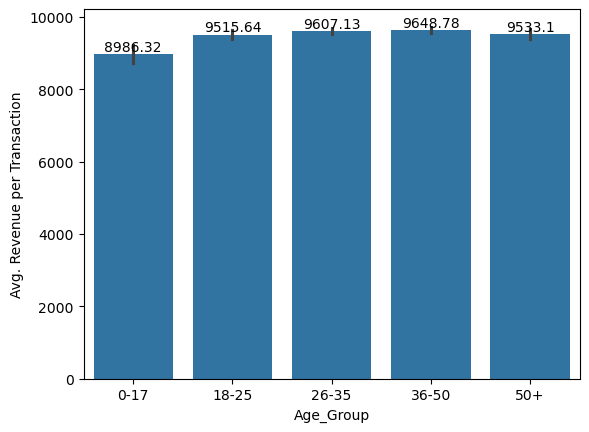

In [249]:
ax = sns.barplot(data= user_agg_data, x= 'Age_Group', y= 'Avg. Revenue per Transaction')

ax.bar_label(ax.containers[0])
plt.show()

*Sample size: 5891 (no. of customers)*

*Data Types: Avg Revenue per Transaction is Numerical and Age is categorical*

*Cardinality: Age has 4 values 0-25, 26-35, 36-45, 46+*

In [250]:
age_0_17_purchase_data = user_agg_data[user_agg_data['Age_Group'] == '0-17']['Avg. Revenue per Transaction']
age_18_25_purchase_data = user_agg_data[user_agg_data['Age_Group'] == '18-25']['Avg. Revenue per Transaction']
age_26_35_purchase_data = user_agg_data[user_agg_data['Age_Group'] == '26-35']['Avg. Revenue per Transaction']
age_36_50_purchase_data = user_agg_data[user_agg_data['Age_Group'] == '36-50']['Avg. Revenue per Transaction']
age_50P_purchase_data = user_agg_data[user_agg_data['Age_Group'] == '50+']['Avg. Revenue per Transaction']

age_group_purchase_data_dict = {
    '0-17'  : age_0_17_purchase_data,
    '18-25'  : age_18_25_purchase_data,
    '26-35' : age_26_35_purchase_data,
    '36-50' : age_36_50_purchase_data,
    '50+'   : age_50P_purchase_data
}


**Assumption: Average spending does not follow a normal distribution as per the ks test**

**Checking for the null hypothesis using Kruskal Wallis Test with two tailed alternative hypothesis**


In [251]:
ks_stat, p_val = st.kruskal(age_0_17_purchase_data, age_18_25_purchase_data, age_26_35_purchase_data, age_36_50_purchase_data, age_50P_purchase_data)

print(f"ks_stat: {ks_stat:4f}, p_val: {p_val:4f}")


alpha = 0.05
if p_val > alpha:
    print(f"There is no significant difference in median of avg purchase amount between age groups at {int((1 - alpha)*100)}% confidence level")
else:
    print(f"There is a significant difference in median of avg purchase amount between age groups at {int((1 - alpha)*100)}% confidence level")

ks_stat: 27.391812, p_val: 0.000017
There is a significant difference in median of avg purchase amount between age groups at 95% confidence level


### Observations:
- The median of average spending amount **is significantly different** between age groups of customers

**Assumption: Average spending follows almost normal distribution as per the qq plot, despite the ks test showing otherwise**

**Checking for homoscedasticity using Levene's test for applying ANOVA Test**

In [252]:
l_stat, p_val = st.levene(age_0_17_purchase_data, age_18_25_purchase_data, age_26_35_purchase_data, age_36_50_purchase_data, age_50P_purchase_data)

print(f"l_stat: {l_stat:4f}, p_val: {p_val:4f}")


alpha = 0.05
if p_val > alpha:
    print(f"There is no significant difference variances of avg spending between age groups at {int((1 - alpha)*100)}% confidence level")
else:
    print(f"There is a significant difference variances of avg spending between age groups at {int((1 - alpha)*100)}% confidence level")

l_stat: 2.761620, p_val: 0.026140
There is a significant difference variances of avg spending between age groups at 95% confidence level


### Observation:
- There is a significant difference in variances across age groups at 95% confidence level
- The result would change to having equal variance at 99% confidence level
- Perform ANOVA nevertheless based on 99% confidence result to make sure again that there is no difference

**Checking for the null hypothesis using ANOVA Test**

In [253]:
f_stat, p_val = st.f_oneway(age_0_17_purchase_data, age_18_25_purchase_data, age_26_35_purchase_data, age_36_50_purchase_data, age_50P_purchase_data)

print(f"f_stat: {f_stat:4f}, p_val: {p_val:4f}")


alpha = 0.05
if p_val > alpha:
    print(f"There is no significant difference between avg spending between age groups of customers at {int((1 - alpha)*100)}% confidence level")
else:
    print(f"There is a significant difference between avg spending between age groups of customers at {int((1 - alpha)*100)}% confidence level")

f_stat: 6.458619, p_val: 0.000035
There is a significant difference between avg spending between age groups of customers at 95% confidence level


### Observations:
- ANOVA: There is a significant difference between avg spending between age groups of customers
- Kruskal Wallis: ANOVA: There is a significant difference between avg spending between age groups of customers
- Both the tests result in the same conclusion that the average spending behaviour is different across age groups

### Next Steps:

- Apply ttest for all combinations to identify similar and significantly different groups
- Merge the subsequent groups that are not significantly different
- Compare the confidence intervals of the final groups and check for overlaps

In [254]:
def get_ttest_result(left_data, right_data, alpha):
    
    two_tailed_t_stat, two_tailed_p_val = st.ttest_ind(left_data, right_data, alternative= 'two-sided')

    two_tailed_result = 'same' if two_tailed_p_val > alpha else 'different'

    alternative = 'less' if left_data.mean() < right_data.mean() else 'greater'

    one_tailed_t_stat, one_tailed_p_val = st.ttest_ind(left_data, right_data, alternative= alternative)

    one_tailed_result = 'same' if one_tailed_p_val > alpha else alternative

    result = {
        'two_tailed_p_val'  : round(two_tailed_p_val, 5),
        'two_tailed_result' : two_tailed_result,
        'one_tailed_p_val'  : round(one_tailed_p_val, 5),
        'one_tailed_result' : one_tailed_result
    }

    return result

**Calculating the ttest results and confidence intervals of avg purchase amount for all combinations of age groups**

In [255]:
age_group_names = list(age_group_purchase_data_dict.keys())
age_group_ttest_results_data = pd.DataFrame()
alpha= 0.05; width = 1 - alpha

for i in range(len(age_group_names)):
    for j in range(i + 1, len(age_group_names)):

        result = dict()
        result['left_age_group'], result['right_age_group'] = age_group_names[i], age_group_names[j]
        result.update(
            get_ttest_result(
                age_group_purchase_data_dict[age_group_names[i]],
                age_group_purchase_data_dict[age_group_names[j]],
                alpha
            )
        )
        left_confidence_interval = get_confidence_interval(
            age_group_purchase_data_dict[age_group_names[i]], sample_pct= 1, width= 1 - alpha
            )
        right_confidence_interval = get_confidence_interval(
            age_group_purchase_data_dict[age_group_names[j]], sample_pct= 1, width= 1 - alpha
            )

        result.update(
            {
                'left_interval': f'[{left_confidence_interval[0]:2f}, {left_confidence_interval[1]:2f}]',
                'right_interval': f'[{right_confidence_interval[0]:2f}, {right_confidence_interval[1]:2f}]',
                'overlap_status': check_overlap(left_confidence_interval, right_confidence_interval)
            }
        )
        result_data = pd.DataFrame(
            data= result, index= [0]
        )
        
        age_group_ttest_results_data = pd.concat([age_group_ttest_results_data, result_data], ignore_index= True)

age_group_ttest_results_data

,left_age_group,right_age_group,two_tailed_p_val,two_tailed_result,one_tailed_p_val,one_tailed_result,left_interval,right_interval,overlap_status
0,0-17,18-25,0.00034,different,0.00017,less,"[8729.913649, 9174.639404]","[9396.177701, 9603.375240]",No Overlap
1,0-17,26-35,0.00000,different,0.00000,less,"[8729.913649, 9174.639404]","[9528.202654, 9665.094255]",No Overlap
2,0-17,36-50,0.00000,different,0.00000,less,"[8729.913649, 9174.639404]","[9560.901632, 9713.330298]",No Overlap
3,0-17,50+,0.00024,different,0.00012,less,"[8729.913649, 9174.639404]","[9401.542800, 9629.729789]",No Overlap
4,18-25,26-35,0.19796,same,0.09898,same,"[9396.177701, 9603.375240]","[9528.202654, 9665.094255]",Overlap
5,18-25,36-50,0.07354,same,0.03677,less,"[9396.177701, 9603.375240]","[9560.901632, 9713.330298]",Overlap
6,18-25,50+,0.84753,same,0.42377,same,"[9396.177701, 9603.375240]","[9401.542800, 9629.729789]",Overlap
7,26-35,36-50,0.48896,same,0.24448,same,"[9528.202654, 9665.094255]","[9560.901632, 9713.330298]",Overlap
8,26-35,50+,0.33008,same,0.16504,same,"[9528.202654, 9665.094255]","[9401.542800, 9629.729789]",Overlap
9,36-50,50+,0.14401,same,0.07201,same,"[9560.901632, 9713.330298]","[9401.542800, 9629.729789]",Overlap


### Observations:

- The avg purchase amount of 0-17 age group is significantly lesses from other groups without overlap
- The other groups have similar average purchase value among each other with overlaps for exceptions
- A final grouping of 0-17, 18+ will be useful for further analysis and actionable insights

In [256]:
age_group_final_mapping = {
    '0-17': '0-17',
    '18-25': '18+',
    '26-35': '18+',
    '36-45': '18+',
    '46-50': '18+',
    '51-55': '18+',
    '55+': '18+'
}

user_agg_data['Age_Group_Final'] = user_agg_data['Age'].map(age_group_final_mapping).astype('category')


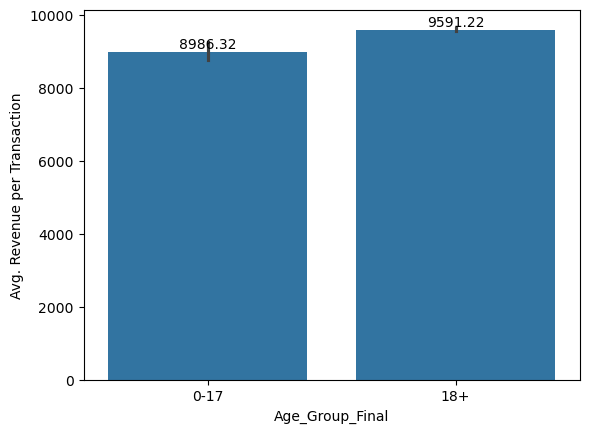

In [257]:
ax = sns.barplot(data= user_agg_data, x= 'Age_Group_Final', y= 'Avg. Revenue per Transaction')

ax.bar_label(ax.containers[0])
plt.show()

**Validating the overlap of confidence intervals for age <18 and 18+ avg purchase amount at different widths and sample sizes**

In [258]:
age_final_L17_purchase_data = user_agg_data[user_agg_data['Age_Group_Final'] == '0-17']['Avg. Revenue per Transaction']
age_final_18P_purchase_data = user_agg_data[user_agg_data['Age_Group_Final'] == '18+']['Avg. Revenue per Transaction']

In [259]:
params = {
    'width': [0.90, 0.95, 0.99],
    'sample_pct': [0.10, 0.50, 0.90]
}

confidence_intervals_data = pd.DataFrame()

for w in params['width']:
    for pct in params['sample_pct']:
        age_final_L17_confidence_interval = get_confidence_interval(age_final_L17_purchase_data, sample_pct= pct, width= w)
        age_final_18P_confidence_interval = get_confidence_interval(age_final_18P_purchase_data, sample_pct= pct, width= w)

        current_confidence_intervals = pd.DataFrame(
            {
                'width': w, 'sample_pct': pct,
                'age_L17_interval': f'[{age_final_L17_confidence_interval[0]:2f}, {age_final_L17_confidence_interval[1]:2f}]',
                'age_L17_interval_range': age_final_L17_confidence_interval[1] - age_final_L17_confidence_interval[0],
                'age_18P_interval': f'[{age_final_18P_confidence_interval[0]:2f}, {age_final_18P_confidence_interval[1]:2f}]',
                'age_18P_interval_range': age_final_18P_confidence_interval[1] - age_final_18P_confidence_interval[0],
                'overlap_status': check_overlap(age_final_18P_confidence_interval, age_final_L17_confidence_interval)
            },
            index= [0]
        )

        confidence_intervals_data = (
            pd.concat([confidence_intervals_data, current_confidence_intervals], ignore_index= True)
        )

confidence_intervals_data

,width,sample_pct,age_L17_interval,age_L17_interval_range,age_18P_interval,age_18P_interval_range,overlap_status
0,0.90,0.1,"[8172.082666, 9104.353823]",932.271158,"[9414.995666, 9617.520750]",202.525084,No Overlap
1,0.90,0.5,"[8878.988520, 9356.788911]",477.800391,"[9491.542775, 9584.719630]",93.176855,No Overlap
2,0.90,0.9,"[8765.840258, 9130.363418]",364.523160,"[9548.430451, 9619.078989]",70.648537,No Overlap
3,0.95,0.1,"[7465.943137, 8934.956779]",1469.013643,"[9436.373709, 9693.456378]",257.082670,No Overlap
4,0.95,0.5,"[8552.414182, 9162.016574]",609.602393,"[9570.791704, 9692.926602]",122.134898,No Overlap
5,0.95,0.9,"[8670.648766, 9139.040310]",468.391544,"[9545.756790, 9635.803676]",90.046886,No Overlap
6,0.99,0.1,"[7985.044500, 10546.178026]",2561.133526,"[9408.459888, 9796.067001]",387.607113,Overlap
7,0.99,0.5,"[8324.958658, 9227.383021]",902.424363,"[9500.111477, 9666.781908]",166.670431,No Overlap
8,0.99,0.9,"[8651.581086, 9313.800075]",662.218989,"[9536.569180, 9662.104115]",125.534936,No Overlap


### Observations:

- There is no overlap at most of the combinations of width and sample sizes between confidence intervals of age <17 and 18+ customers, except for 99% width and 10% sample pct
- Hence, it can be concluded that there **is a significant difference** between avg spend amount for age <17 vs 18+ customers

## City Category

*Metric: Avg purchase amount per transaction*

*Null Hypothesis (H0): There is no significant difference across city categories*

*Alternate Hypothesis(Ha): Avg purchase amount is significantly different across city categories*


In [260]:
# Checking for data types and cardinality and sample size

print(user_agg_data['Avg. Revenue per Transaction'].dtype, user_agg_data['City_Category'].dtype)

print(user_agg_data['Avg. Revenue per Transaction'].shape, user_agg_data['City_Category'].nunique())

user_agg_data['City_Category'].value_counts()

float64 category
(5891,) 3


City_Category
C    3139
B    1707
A    1045
Name: count, dtype: int64

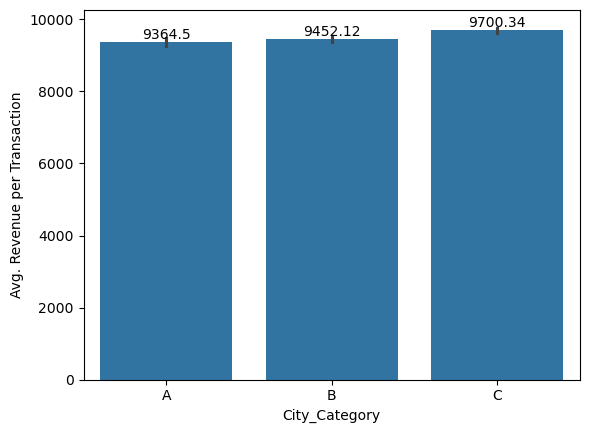

In [261]:
ax = sns.barplot(data= user_agg_data, x= 'City_Category', y= 'Avg. Revenue per Transaction')

ax.bar_label(ax.containers[0])
plt.show()

*Sample size: 5891 (no. of customers)*

*Data Types: Avg Revenue per Transaction is Numerical and City Category is categorical*

*Cardinality: City Category has 3 values A, B, C*

In [262]:
city_A_purchase_data = user_agg_data[user_agg_data['City_Category'] == 'A']['Avg. Revenue per Transaction']
city_B_purchase_data = user_agg_data[user_agg_data['City_Category'] == 'B']['Avg. Revenue per Transaction']
city_C_purchase_data = user_agg_data[user_agg_data['City_Category'] == 'C']['Avg. Revenue per Transaction']

city_category_purchase_data_dict = {
    'A' : city_A_purchase_data,
    'B' : city_B_purchase_data,
    'C' : city_C_purchase_data,
}


**Assumption: Average spending does not follow a normal distribution (as per the ks test)**

**Checking for the null hypothesis using Kruskal Wallis Test with two tailed alternative hypothesis**


In [263]:
ks_stat, p_val = st.kruskal(city_A_purchase_data, city_B_purchase_data, city_C_purchase_data)

print(f"ks_stat: {ks_stat:4f}, p_val: {p_val:4f}")


alpha = 0.05
if p_val > alpha:
    print(f"There is no significant difference in median of avg purchase amount between city categories at {int((1 - alpha)*100)}% confidence level")
else:
    print(f"There is a significant difference in median of avg purchase amount between city categories at {int((1 - alpha)*100)}% confidence level")

ks_stat: 32.399297, p_val: 0.000000
There is a significant difference in median of avg purchase amount between city categories at 95% confidence level


### Observations:
- The median of average spending amount **is significantly different** between city categories of customers

**Assumption: Average spending follows almost normal distribution as per the qq plot, despite the ks test showing otherwise**

**Checking for homoscedasticity using Levene's test for applying ANOVA Test**

In [264]:
l_stat, p_val = st.levene(city_A_purchase_data, city_B_purchase_data, city_C_purchase_data)

print(f"l_stat: {l_stat:4f}, p_val: {p_val:4f}")


alpha = 0.05
if p_val > alpha:
    print(f"There is no significant difference variances of avg spending between city categories at {int((1 - alpha)*100)}% confidence level")
else:
    print(f"There is a significant difference variances of avg spending between city categories at {int((1 - alpha)*100)}% confidence level")

l_stat: 16.735004, p_val: 0.000000
There is a significant difference variances of avg spending between city categories at 95% confidence level


### Observation:
- There is a significant difference in variances across city categories at 95% confidence level
- Hence, ANOVA test can not be applied in this scenario

### Observations:
- Kruskal Wallis: There is a significant difference between avg spending between city groups of customers

### Next Steps:

- Apply ttest for all combinations to identify similar and significantly different groups
- Merge the subsequent groups that are not significantly different
- Compare the confidence intervals of the final groups and check for overlaps

**Calculating the ttest results and confidence intervals of avg purchase amount for all combinations of age groups**

In [265]:
city_category_names = ['C', 'A', 'B']#list(city_category_purchase_data_dict.keys())
city_category_ttest_results_data = pd.DataFrame()
alpha= 0.05; width = 1 - alpha

for i in range(len(city_category_names)):
    for j in range(i + 1, len(city_category_names)):

        result = dict()
        result['left_city_category'], result['right_city_category'] = city_category_names[i], city_category_names[j]
        result.update(
            get_ttest_result(
                city_category_purchase_data_dict[city_category_names[i]],
                city_category_purchase_data_dict[city_category_names[j]],
                alpha
            )
        )
        left_confidence_interval = get_confidence_interval(
            city_category_purchase_data_dict[city_category_names[i]], sample_pct= 1, width= 1 - alpha
            )
        right_confidence_interval = get_confidence_interval(
            city_category_purchase_data_dict[city_category_names[j]], sample_pct= 1, width= 1 - alpha
            )

        result.update(
            {
                'left_interval': f'[{left_confidence_interval[0]:2f}, {left_confidence_interval[1]:2f}]',
                'right_interval': f'[{right_confidence_interval[0]:2f}, {right_confidence_interval[1]:2f}]',
                'overlap_status': check_overlap(left_confidence_interval, right_confidence_interval)
            }
        )
        result_data = pd.DataFrame(
            data= result, index= [0]
        )
        
        city_category_ttest_results_data = pd.concat([city_category_ttest_results_data, result_data], ignore_index= True)

city_category_ttest_results_data

,left_city_category,right_city_category,two_tailed_p_val,two_tailed_result,one_tailed_p_val,one_tailed_result,left_interval,right_interval,overlap_status
0,C,A,0.00000,different,0.00000,greater,"[9631.341935, 9751.015584]","[9254.039063, 9445.625139]",No Overlap
1,C,B,0.00001,different,0.00001,greater,"[9631.341935, 9751.015584]","[9368.916691, 9513.232904]",No Overlap
2,A,B,0.21021,same,0.10510,same,"[9254.039063, 9445.625139]","[9368.916691, 9513.232904]",Overlap


### Observations:

- The avg purchase amount of city C is significantly greater that other groups
- The avg purchase amount of city A and B are same

In [266]:
city_category_final_mapping = {
    'A': 'AB',
    'B': 'AB',
    'C': 'C',
}

user_agg_data['City_Category_Final'] = user_agg_data['City_Category'].map(city_category_final_mapping).astype('category')


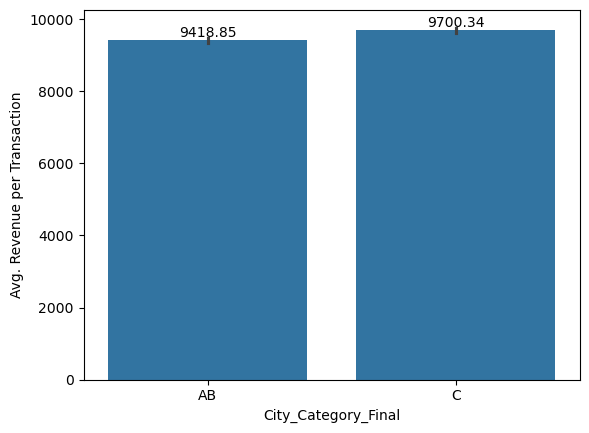

In [267]:
ax = sns.barplot(data= user_agg_data, x= 'City_Category_Final', y= 'Avg. Revenue per Transaction')

ax.bar_label(ax.containers[0])
plt.show()

**Validating the overlap of confidence intervals for age <18 and 18+ avg purchase amount at different widths and sample sizes**

In [268]:
city_category_final_AB_purchase_data = user_agg_data[user_agg_data['City_Category_Final'] == 'AB']['Avg. Revenue per Transaction']
city_category_final_C_purchase_data = user_agg_data[user_agg_data['City_Category_Final'] == 'C']['Avg. Revenue per Transaction']

In [269]:
params = {
    'width': [0.90, 0.95, 0.99],
    'sample_pct': [0.10, 0.50, 0.90]
}

confidence_intervals_data = pd.DataFrame()

for w in params['width']:
    for pct in params['sample_pct']:
        city_category_final_AB_confidence_interval = get_confidence_interval(city_category_final_AB_purchase_data, sample_pct= pct, width= w)
        city_category_final_C_confidence_interval = get_confidence_interval(city_category_final_C_purchase_data, sample_pct= pct, width= w)

        current_confidence_intervals = pd.DataFrame(
            {
                'width': w, 'sample_pct': pct,
                'city_AB_interval': f'[{city_category_final_AB_confidence_interval[0]:2f}, {city_category_final_AB_confidence_interval[1]:2f}]',
                'city_AB_interval_range': city_category_final_AB_confidence_interval[1] - city_category_final_AB_confidence_interval[0],
                'city_C_interval': f'[{city_category_final_C_confidence_interval[0]:2f}, {city_category_final_C_confidence_interval[1]:2f}]',
                'city_C_interval_range': city_category_final_C_confidence_interval[1] - city_category_final_C_confidence_interval[0],
                'overlap_status': check_overlap(city_category_final_C_confidence_interval, city_category_final_AB_confidence_interval)
            },
            index= [0]
        )

        confidence_intervals_data = (
            pd.concat([confidence_intervals_data, current_confidence_intervals], ignore_index= True)
        )

confidence_intervals_data

,width,sample_pct,city_AB_interval,city_AB_interval_range,city_C_interval,city_C_interval_range,overlap_status
0,0.90,0.1,"[9319.971645, 9591.363296]",271.391651,"[9706.959361, 9993.801857]",286.842496,No Overlap
1,0.90,0.5,"[9314.181568, 9439.587440]",125.405872,"[9569.502847, 9704.442070]",134.939223,No Overlap
2,0.90,0.9,"[9351.987576, 9448.468808]",96.481232,"[9639.255164, 9738.024273]",98.769109,No Overlap
3,0.95,0.1,"[9282.340150, 9636.083755]",353.743605,"[9503.037288, 9898.341177]",395.303889,Overlap
4,0.95,0.5,"[9384.262258, 9547.979187]",163.716929,"[9587.968821, 9755.288695]",167.319874,No Overlap
5,0.95,0.9,"[9345.947851, 9467.462767]",121.514916,"[9621.815937, 9748.504479]",126.688542,No Overlap
6,0.99,0.1,"[8999.247082, 9471.147349]",471.900266,"[9234.455547, 9777.742436]",543.286889,Overlap
7,0.99,0.5,"[9281.139745, 9512.264686]",231.124941,"[9535.486233, 9771.070742]",235.584509,No Overlap
8,0.99,0.9,"[9321.654931, 9490.586648]",168.931717,"[9587.557099, 9764.070940]",176.513841,No Overlap


### Observations:

- There is no overlap at most of the combinations of width and sample sizes between confidence intervals of city category AB vs city C customers, except for 10% sample pct at 95% and 99% confidence intervals
- Hence, it can be concluded that there **is a significant difference** between avg spend amount for city category AB vs city C customers